In [ ]:
#install missing libraries by uncommenting the codes below

#!pip install "pymc>=5"
#!pip install numpy
#!pip install pandas
#!pip install seaborn
#!pip install bambi
#!pip install bambi


In [1]:
# import imporotant libraries for our analysis

import pymc as pm
import bambi as bmb
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import pytensor.tensor as pt

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

random_seed= 42


In [2]:
#read the data

aki_join=pd.read_csv("./data/aki_field_wgs84_join_ranges.csv")
aki_2016_fields=pd.read_csv("./data/parcellahoz_rendelt_agazati_adatok_2016.csv")
nabi_2016_fields=pd.read_csv("./data/ANL_GN02_2016.csv")
# Set Pandas display options to show all columns
pd.set_option('display.max_columns', None)

aki_join.head()

,bloaz,pH_KCl,KA,Ossz_so,CaCO3,Humusz,NO3_N,P2O5,K2O,Mg,Na,Zn,Cu,Mn,SO4,pH_KCl_range,KA_range,Ossz_so_range,CaCO3_range,Humusz_range,NO3_N_range,P2O5_range,K2O_range,Mg_range,Na_range,Zn_range,Cu_range,Mn_range,SO4_range
0,K46VEC12,7.20,59.0,0.03,14.80,2.3000,22.8,383.90,260.4000,335.50,46.5,1.700,5.000,19.70,5.0,50%-75%,Upper-range,50%-75%,Upper-range,50%-75%,50%-75%,Upper-range,50%-75%,50%-75%,Upper-range,50%-75%,Upper-range,Low-range,Low-range
1,J20L8M13,7.50,40.0,0.02,12.90,1.7000,20.8,217.70,171.0000,116.70,15.5,0.600,1.200,8.50,5.0,Upper-range,Low-range,Low-range,Upper-range,25%-50%,50%-75%,50%-75%,25%-50%,Low-range,Low-range,Low-range,Low-range,Low-range,Low-range
2,V1MAEH13,5.80,44.0,0.03,0.20,1.1000,57.5,64.20,160.8000,370.90,25.7,0.600,1.600,170.40,7.7,25%-50%,25%-50%,50%-75%,Low-range,Low-range,Upper-range,Low-range,Low-range,50%-75%,25%-50%,Low-range,Low-range,50%-75%,Upper-range
3,NWEWV113,7.49,36.0,0.02,5.33,2.3573,11.8,72.09,216.0565,78.96,32.4,0.597,1.841,28.42,50.1,Upper-range,Low-range,Low-range,Upper-range,50%-75%,25%-50%,Low-range,25%-50%,Low-range,50%-75%,Low-range,25%-50%,Low-range,Upper-range
4,VJ7HHU13,7.40,46.0,0.02,3.10,2.3000,18.9,137.30,225.6000,158.60,28.0,0.600,1.200,13.60,5.0,Upper-range,25%-50%,Low-range,Upper-range,50%-75%,50%-75%,25%-50%,50%-75%,25%-50%,25%-50%,Low-range,Low-range,Low-range,Low-range


In [3]:
#look at the header of the AKI 2016 dataset
aki_2016_fields.head()

,akod,agazat,e0109_03,field_id,rnb,area,e0700_04,yield,termes_meny,total_income,total_income.1,vetomag_ktsg,mutragya_ktsg,novved_ktsg,gep_ktsg,ossz_ktsg,total_cost,profit
0,02/0037,1312,repce,CF8EK913,28,23.53,3100,3.1,72.9,9601200,7920000,672000,1080000,1480800,860976,6909704,6187109,2691496
1,04/0105,1111,őszi búza,EC0C4J15,17,41.08,5520,5.5,226.8,10820574,7940818,1097500,1470000,157500,0,9791016,7199042,1029558
2,04/0152,1113,őszi árpa,E07V7115,1,35.00,4500,4.5,157.5,3455250,2404500,320000,260400,162000,346793,2049653,2712850,1405597
3,04/0158,1113,őszi árpa,E0Y99815,6,3.47,3850,3.9,13.4,617662,81072,14367,43321,14548,120351,403095,545427,214567
4,04/0158,1113,őszi árpa,E27PC215,44,9.83,4050,4.1,39.8,1840642,241596,42813,129096,43353,358649,1201230,1625379,639412


In [4]:
#look at the data dimension
print(aki_join.shape)
print(aki_2016_fields.shape)
print(nabi_2016_fields.shape)

(1979, 29)
(673, 18)
(81151, 18)


In [5]:
#join the aki_join_fields and aki_2016_field (673)
# so that we can merge soil data and financial data
aki_complete=aki_2016_fields.merge(aki_join[["bloaz","pH_KCl","KA","Humusz","Humusz_range","pH_KCl_range","KA_range"]], left_on="field_id", right_on="bloaz", how="left")
print(aki_complete.shape)
aki_complete.head()

(673, 25)


,akod,agazat,e0109_03,field_id,rnb,area,e0700_04,yield,termes_meny,total_income,total_income.1,vetomag_ktsg,mutragya_ktsg,novved_ktsg,gep_ktsg,ossz_ktsg,total_cost,profit,bloaz,pH_KCl,KA,Humusz,Humusz_range,pH_KCl_range,KA_range
0,02/0037,1312,repce,CF8EK913,28,23.53,3100,3.1,72.9,9601200,7920000,672000,1080000,1480800,860976,6909704,6187109,2691496,CF8EK913,7.40,46.0,1.1000,Low-range,Upper-range,25%-50%
1,04/0105,1111,őszi búza,EC0C4J15,17,41.08,5520,5.5,226.8,10820574,7940818,1097500,1470000,157500,0,9791016,7199042,1029558,EC0C4J15,7.30,46.0,2.7000,Upper-range,50%-75%,25%-50%
2,04/0152,1113,őszi árpa,E07V7115,1,35.00,4500,4.5,157.5,3455250,2404500,320000,260400,162000,346793,2049653,2712850,1405597,E07V7115,5.77,58.0,3.1394,Upper-range,25%-50%,Upper-range
3,04/0158,1113,őszi árpa,E0Y99815,6,3.47,3850,3.9,13.4,617662,81072,14367,43321,14548,120351,403095,545427,214567,E0Y99815,7.30,48.0,2.0000,25%-50%,50%-75%,50%-75%
4,04/0158,1113,őszi árpa,E27PC215,44,9.83,4050,4.1,39.8,1840642,241596,42813,129096,43353,358649,1201230,1625379,639412,E27PC215,7.30,48.0,2.0000,25%-50%,50%-75%,50%-75%


In [6]:
#look at descriptive statistics
aki_complete.describe()

,agazat,rnb,area,e0700_04,yield,termes_meny,total_income,total_income.1,vetomag_ktsg,mutragya_ktsg,novved_ktsg,gep_ktsg,ossz_ktsg,total_cost,profit,pH_KCl,KA,Humusz
count,673.000000,673.000000,673.000000,673.000000,673.000000,673.000000,6.730000e+02,6.730000e+02,6.730000e+02,6.730000e+02,6.730000e+02,6.730000e+02,6.730000e+02,6.730000e+02,6.730000e+02,673.000000,673.000000,673.000000
mean,1170.029718,86.323923,18.382959,6294.138187,6.296731,118.737593,1.226936e+07,9.718595e+06,8.148179e+05,1.544530e+06,1.033755e+06,1.439399e+06,8.847928e+06,8.328866e+06,3.482656e+06,6.673700,43.383358,2.012973
std,87.473818,131.336839,20.294686,2910.891530,2.911429,156.830923,2.803610e+07,2.486829e+07,1.609261e+06,4.314205e+06,3.161997e+06,2.889333e+06,2.154637e+07,1.796919e+07,7.114006e+06,0.864121,10.889946,0.887408
min,1111.000000,1.000000,0.300000,1200.000000,1.200000,2.300000,1.475460e+05,0.000000e+00,7.634000e+03,1.415400e+04,3.022000e+03,0.000000e+00,9.829600e+04,1.222510e+05,8.430000e+02,4.860000,25.000000,0.400000
25%,1111.000000,17.000000,5.070000,3706.000000,3.700000,27.600000,2.056729e+06,1.195483e+06,1.355730e+05,2.199040e+05,1.139990e+05,2.464670e+05,1.417493e+06,1.502875e+06,5.548560e+05,5.800000,37.000000,1.100000
50%,1121.000000,49.000000,11.960000,5519.000000,5.500000,67.700000,5.384233e+06,3.731362e+06,3.384480e+05,6.274240e+05,3.201840e+05,6.534280e+05,3.979582e+06,3.785811e+06,1.456204e+06,7.200000,46.000000,2.000000
75%,1311.000000,100.000000,23.800000,8520.000000,8.500000,147.500000,1.298982e+07,9.407420e+06,8.940720e+05,1.534367e+06,9.109430e+05,1.622427e+06,9.016248e+06,8.810588e+06,3.906856e+06,7.300000,50.000000,2.900000
max,1312.000000,899.000000,195.000000,15060.000000,15.100000,1579.500000,4.468169e+08,4.194091e+08,2.883779e+07,7.569710e+07,5.523045e+07,4.559084e+07,3.672935e+08,2.881791e+08,1.148474e+08,7.800000,68.000000,3.800000


In [7]:
#calculate the yield per total area
# and calculate the correlation between a subset of numeric variables
aki_complete["new_yield"]=aki_complete["yield"]*aki_complete["area"]
aki_complete[["area","new_yield","total_income","total_cost","profit","pH_KCl","KA","Humusz"]].corr()

,area,new_yield,total_income,total_cost,profit,pH_KCl,KA,Humusz
area,1.000000,0.882970,0.580708,0.588717,0.524714,-0.049914,0.083309,-0.066532
new_yield,0.882970,1.000000,0.586142,0.593283,0.552375,-0.059466,0.054168,-0.072807
total_income,0.580708,0.586142,1.000000,0.996146,0.934055,0.004717,0.074744,-0.003441
total_cost,0.588717,0.593283,0.996146,1.000000,0.954954,0.017719,0.088481,0.010909
profit,0.524714,0.552375,0.934055,0.954954,1.000000,0.060387,0.074782,0.039084
pH_KCl,-0.049914,-0.059466,0.004717,0.017719,0.060387,1.000000,-0.060624,0.431130
KA,0.083309,0.054168,0.074744,0.088481,0.074782,-0.060624,1.000000,0.558680
Humusz,-0.066532,-0.072807,-0.003441,0.010909,0.039084,0.431130,0.558680,1.000000


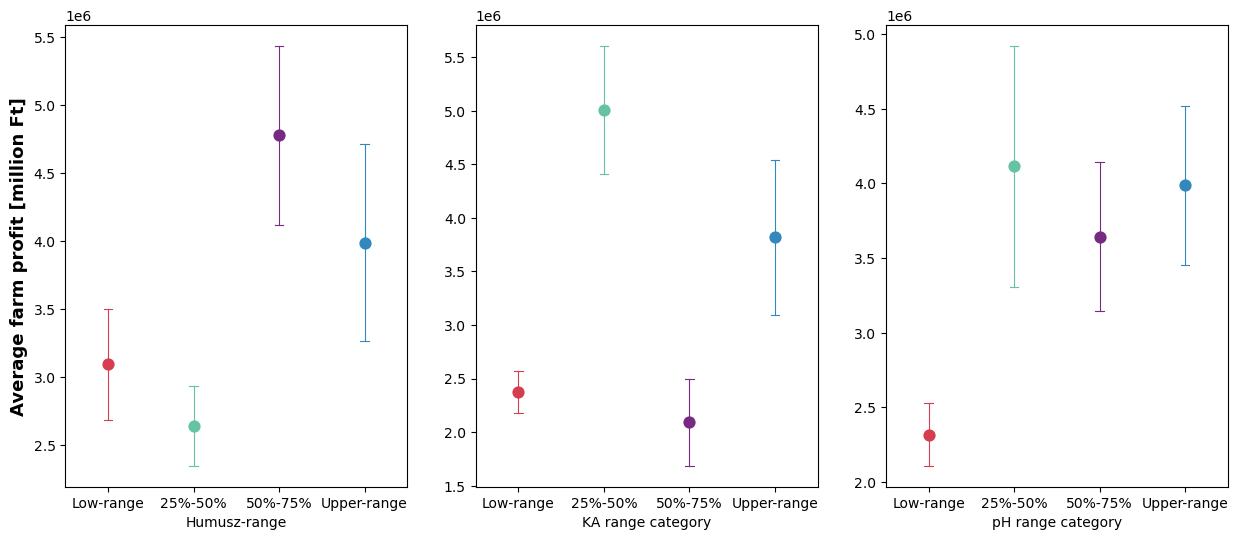

In [8]:
#plot descriptive stastistics of the data. Here, we aim to assess the distribution of profit across a a range of pH, Humusz and soil plasticity
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

fig=plt.figure(figsize=[15,6])
classes={"Low-range":"#d53e4f","25%-50%":"#66c2a5","50%-75%":"#762a83","Upper-range":"#3288bd"}

plt.subplot(1,3,1)
ax=sns.pointplot(aki_complete, x="Humusz_range", y="profit", estimator="mean",errorbar="se",errwidth=0.8,capsize=0.1,order=classes, palette=classes)
#ax.bar_label(ax.containers[0], fontsize=10)
plt.xlabel("Humusz-range")
plt.ylabel("Average farm profit [million Ft]", size=13, weight="bold")



plt.subplot(1,3,2)
ax=sns.pointplot(aki_complete, x="KA_range", y="profit", estimator="mean",errorbar="se",errwidth=0.8,capsize=0.1,order=classes,palette=classes)
#ax.bar_label(ax.containers[0], fontsize=10)
plt.xlabel("KA range category")
plt.ylabel("")

plt.subplot(1,3,3)
ax=sns.pointplot(aki_complete, x="pH_KCl_range", y="profit", estimator="mean",errorbar="se",errwidth=0.8,capsize=0.1,order=classes, palette=classes)
#ax.bar_label(ax.containers[0], fontsize=10)
plt.xlabel("pH range category")
plt.ylabel("");


#fig.savefig("/home/drdc/Documents/drdc/open_projects/soilweb/4_results/Figure6.png",dpi=300)

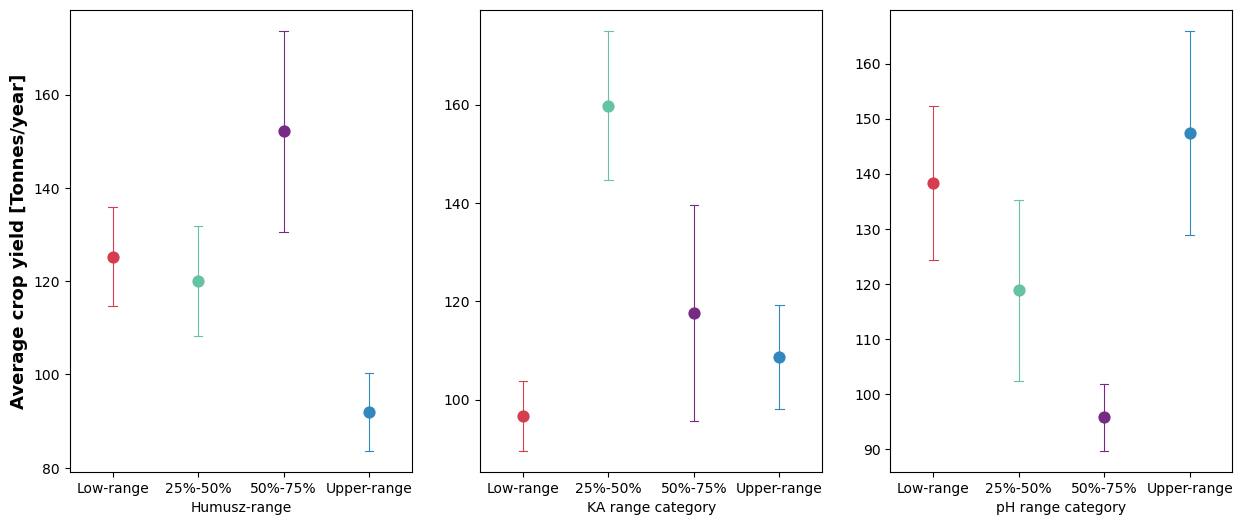

In [9]:
#plot descriptive stastistics of the data. Here, we aim to assess the distribution of yield across a a range of pH, Humusz and soil plasticity
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

fig=plt.figure(figsize=[15,6])
classes={"Low-range":"#d53e4f","25%-50%":"#66c2a5","50%-75%":"#762a83","Upper-range":"#3288bd"}

plt.subplot(1,3,1)
ax=sns.pointplot(aki_complete, x="Humusz_range", y="new_yield", estimator="mean",errorbar="se",errwidth=0.8,capsize=0.1,order=classes, palette=classes)
#ax.bar_label(ax.containers[0], fontsize=10)
plt.xlabel("Humusz-range")
plt.ylabel("Average crop yield [Tonnes/year]", size=13, weight="bold")


plt.subplot(1,3,2)
ax=sns.pointplot(aki_complete, x="KA_range", y="new_yield", estimator="mean",errorbar="se",errwidth=0.8,capsize=0.1,order=classes,palette=classes)
#ax.bar_label(ax.containers[0], fontsize=10)
plt.xlabel("KA range category")
plt.ylabel("")

plt.subplot(1,3,3)
ax=sns.pointplot(aki_complete, x="pH_KCl_range", y="new_yield", estimator="mean",errorbar="se",errwidth=0.8,capsize=0.1,order=classes, palette=classes)
#ax.bar_label(ax.containers[0], fontsize=10)
plt.xlabel("pH range category")
plt.ylabel("");


#fig.savefig("/home/drdc/Documents/drdc/open_projects/soilweb/4_results/Figure6.png",dpi=300)

In [10]:
#join the aki_join_fields and NABI data

df_complete=aki_complete.merge(nabi_2016_fields[["MEPAR_BLOKKAZONOSITO","MUTRAGYA_KIJ_N","MUTRAGYA_KIJ_P2O5","MUTRAGYA_KIJ_K2O","TERMESHOZAM_TENY"]], left_on=["bloaz"], right_on="MEPAR_BLOKKAZONOSITO", how="inner")
print(df_complete.shape)
df_complete.head()

(721, 31)


,akod,agazat,e0109_03,field_id,rnb,area,e0700_04,yield,termes_meny,total_income,total_income.1,vetomag_ktsg,mutragya_ktsg,novved_ktsg,gep_ktsg,ossz_ktsg,total_cost,profit,bloaz,pH_KCl,KA,Humusz,Humusz_range,pH_KCl_range,KA_range,new_yield,MEPAR_BLOKKAZONOSITO,MUTRAGYA_KIJ_N,MUTRAGYA_KIJ_P2O5,MUTRAGYA_KIJ_K2O,TERMESHOZAM_TENY
0,02/0037,1312,repce,CF8EK913,28,23.53,3100,3.1,72.9,9601200,7920000,672000,1080000,1480800,860976,6909704,6187109,2691496,CF8EK913,7.40,46.0,1.1000,Low-range,Upper-range,25%-50%,72.943,CF8EK913,145.8,0.0,0.0,3.0
1,04/0152,1113,őszi árpa,E07V7115,1,35.00,4500,4.5,157.5,3455250,2404500,320000,260400,162000,346793,2049653,2712850,1405597,E07V7115,5.77,58.0,3.1394,Upper-range,25%-50%,Upper-range,157.500,E07V7115,59.0,32.0,32.0,4.2
2,04/0158,1113,őszi árpa,E0Y99815,6,3.47,3850,3.9,13.4,617662,81072,14367,43321,14548,120351,403095,545427,214567,E0Y99815,7.30,48.0,2.0000,25%-50%,50%-75%,50%-75%,13.533,E0Y99815,54.0,0.0,0.0,2.0
3,04/0158,1113,őszi árpa,E0Y99815,6,3.47,3850,3.9,13.4,617662,81072,14367,43321,14548,120351,403095,545427,214567,E0Y99815,7.30,48.0,2.0000,25%-50%,50%-75%,50%-75%,13.533,E0Y99815,68.0,0.0,0.0,3.9
4,04/0158,1113,őszi árpa,E0Y99815,6,3.47,3850,3.9,13.4,617662,81072,14367,43321,14548,120351,403095,545427,214567,E0Y99815,7.30,48.0,2.0000,25%-50%,50%-75%,50%-75%,13.533,E0Y99815,0.0,0.0,0.0,0.0


# Bayesian soil-yield-income model


In [13]:
#create a subset of the dataset. Just what is needed for the analysis
df_complete_subset=df_complete[["field_id","pH_KCl","KA","Humusz","MUTRAGYA_KIJ_N","MUTRAGYA_KIJ_P2O5","MUTRAGYA_KIJ_K2O","TERMESHOZAM_TENY","new_yield","profit"]]
df_complete_subset.head()

,field_id,pH_KCl,KA,Humusz,MUTRAGYA_KIJ_N,MUTRAGYA_KIJ_P2O5,MUTRAGYA_KIJ_K2O,TERMESHOZAM_TENY,new_yield,profit
0,CF8EK913,7.40,46.0,1.1000,145.8,0.0,0.0,3.0,72.943,2691496
1,E07V7115,5.77,58.0,3.1394,59.0,32.0,32.0,4.2,157.500,1405597
2,E0Y99815,7.30,48.0,2.0000,54.0,0.0,0.0,2.0,13.533,214567
3,E0Y99815,7.30,48.0,2.0000,68.0,0.0,0.0,3.9,13.533,214567
4,E0Y99815,7.30,48.0,2.0000,0.0,0.0,0.0,0.0,13.533,214567


In [14]:
# calculate the summary statistics.they will be used to setup  some parameters
df_complete_subset.describe()

,pH_KCl,KA,Humusz,MUTRAGYA_KIJ_N,MUTRAGYA_KIJ_P2O5,MUTRAGYA_KIJ_K2O,TERMESHOZAM_TENY,new_yield,profit
count,721.000000,721.000000,721.000000,721.000000,721.000000,721.000000,721.000000,721.000000,7.210000e+02
mean,6.767531,45.420250,2.130709,46.804716,13.666158,11.017753,3.628100,129.071396,6.314616e+06
std,0.832193,9.896384,0.852303,47.909806,25.796773,24.062557,3.978204,152.268321,1.043413e+07
min,4.860000,25.000000,0.400000,0.000000,0.000000,0.000000,0.000000,2.610000,1.982000e+03
25%,5.990000,40.000000,1.200000,0.000000,0.000000,0.000000,0.000000,33.096000,5.548560e+05
50%,7.230000,46.000000,2.000000,33.100000,0.000000,0.000000,3.500000,79.900000,2.444305e+06
75%,7.300000,53.000000,2.900000,81.000000,6.000000,0.100000,5.320000,191.100000,8.788046e+06
max,7.800000,68.000000,3.690000,170.000000,96.000000,180.000000,55.000000,1579.500000,1.148474e+08


In [15]:
# Model definition
seed=42 # to replicate the results
with pm.Model() as agribusiness_model:
    # we will set the priors distributions  for each beta coefficient
    # the paramter set here are somewhat reflecting the distrbution of the database
    pH = pm.Normal('pH', mu=6.76, sigma=0.64)
    KA= pm.Normal('KA', mu=45.42, sigma=9)
    Humusz = pm.Normal('Humusz', mu=2.13, sigma=0.85)
    N= pm.Normal('N', mu=46.8, sigma=4.7)
    P2O5 = pm.Normal('P2O5', mu=13.66, sigma=25.79)
    KO2 = pm.Normal('K2O', mu=11.01, sigma=24.10)

    # Multiple Linear regression model
    mu_yield = (
        pH * df_complete_subset["pH_KCl"] +
        KA * df_complete_subset["KA"] +
        Humusz * df_complete_subset["KA"]  +
        N * df_complete_subset["MUTRAGYA_KIJ_N"] +
        P2O5* df_complete_subset["MUTRAGYA_KIJ_P2O5"]  +
        KO2 * df_complete_subset["MUTRAGYA_KIJ_K2O"]
    )

    # Likelihood of observations
    sigma_yield=pm.HalfCauchy("sigma_yield",1)
    yield_obs = pm.Normal('yield_obs', mu=mu_yield, sigma=sigma_yield, observed=df_complete_subset["new_yield"])


#sample the model
with  agribusiness_model:
    # Sample from the distribution. Note the PYMC uses thew MCMC algorithm
    trace = pm.sample(draws=3000, tune=1000, cores=14, chains=4,random_seed=seed)
#summarizing the results
az.summary(data=trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 14 jobs)
NUTS: [pH, KA, Humusz, N, P2O5, K2O, sigma_yield]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 21 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pH,6.883,0.622,5.742,8.060,0.006,0.004,12032.0,7343.0,1.0
KA,-0.237,0.886,-1.904,1.386,0.010,0.008,8191.0,7453.0,1.0
Humusz,1.702,0.865,0.094,3.327,0.010,0.007,8217.0,7566.0,1.0
N,0.248,0.112,0.035,0.461,0.001,0.001,11699.0,7850.0,1.0
P2O5,-0.577,0.252,-1.031,-0.083,0.002,0.002,11002.0,8778.0,1.0
K2O,0.844,0.268,0.326,1.331,0.003,0.002,10353.0,8061.0,1.0
sigma_yield,153.047,3.996,145.512,160.341,0.037,0.026,11800.0,8734.0,1.0


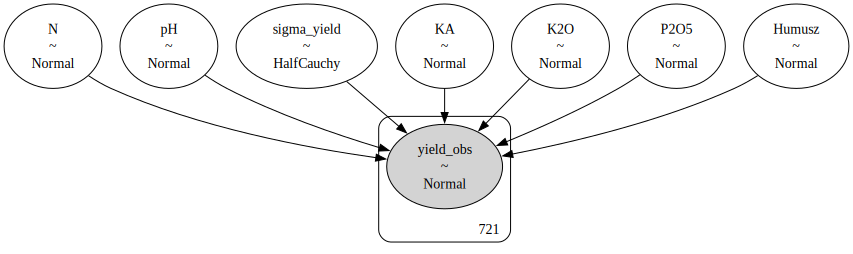

In [16]:
#plot the model structure
pm.model_to_graphviz(agribusiness_model)


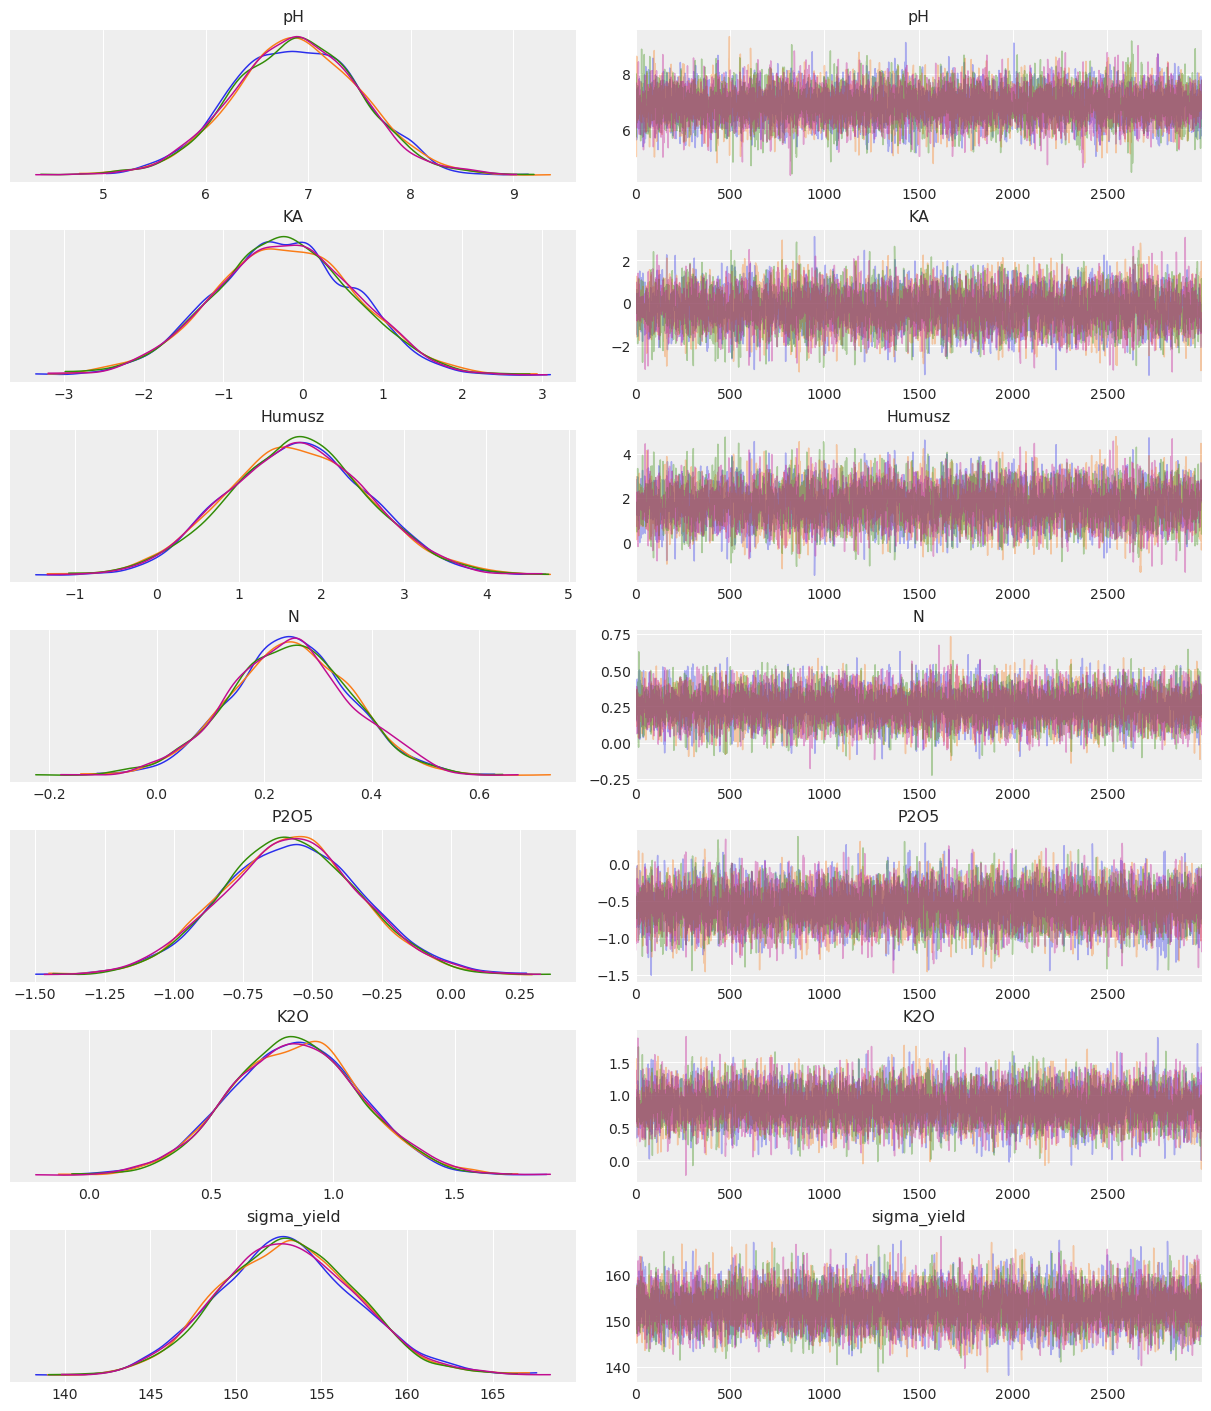

In [17]:
#Analyze sampling results using the trace plot
#The most common used plot to analyze sampling results is the so-called trace-plot:
# Here the plot shows the distribution of all investigated parameters
az.style.use("arviz-darkgrid")
az.plot_trace(trace, compact=False);

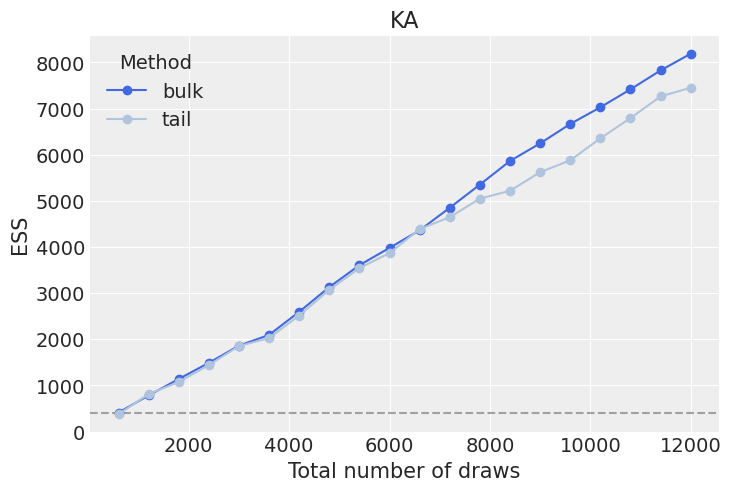

In [19]:
#Estimated effective sample sizes with increasing number of iterations for the model. 
# Checking local and quantile ESS is particularly relevant when working with HDI intervals
extra_kwargs = {"color": "lightsteelblue"}
az.plot_ess(
    trace, kind="evolution", var_names=["KA"],
    color="royalblue", extra_kwargs=extra_kwargs
);

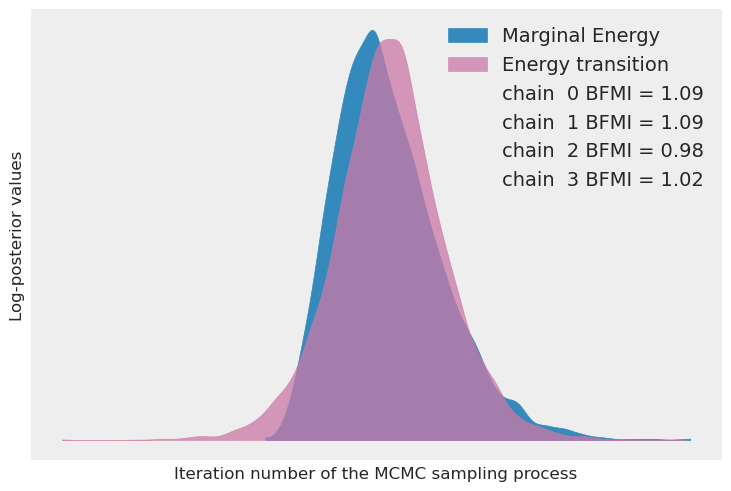

In [20]:
# Plot energy transition distribution and marginal energy distribution in MCMC algorithm.
plt.style.use("bmh")
az.plot_energy(trace)
plt.ylabel("Log-posterior values", size=12)
plt.xlabel("Iteration number of the MCMC sampling process", size=12);
#plt.savefig("/home/drdc/Documents/drdc/open_projects/irrifarm/2_figures/fig11b.png",dpi=300);

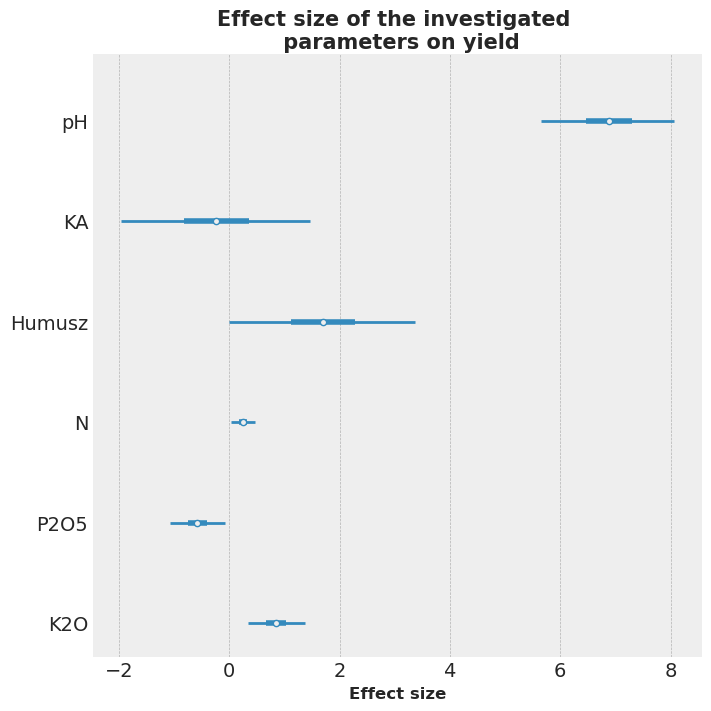

In [22]:
#Forest plot to compare HDI intervals from the investigated independent variable distributions.
az.plot_forest(data=trace, var_names=["pH", "KA","Humusz", "N","P2O5","K2O"], combined=True, hdi_prob=0.95, r_hat=False, figsize=(7,7));
plt.title("Effect size of the investigated \n parameters on yield", size=15, weight="bold")
plt.xlabel("Effect size", size=12, weight="bold");
#plt.savefig("./figures/fig2.png",dpi=300);

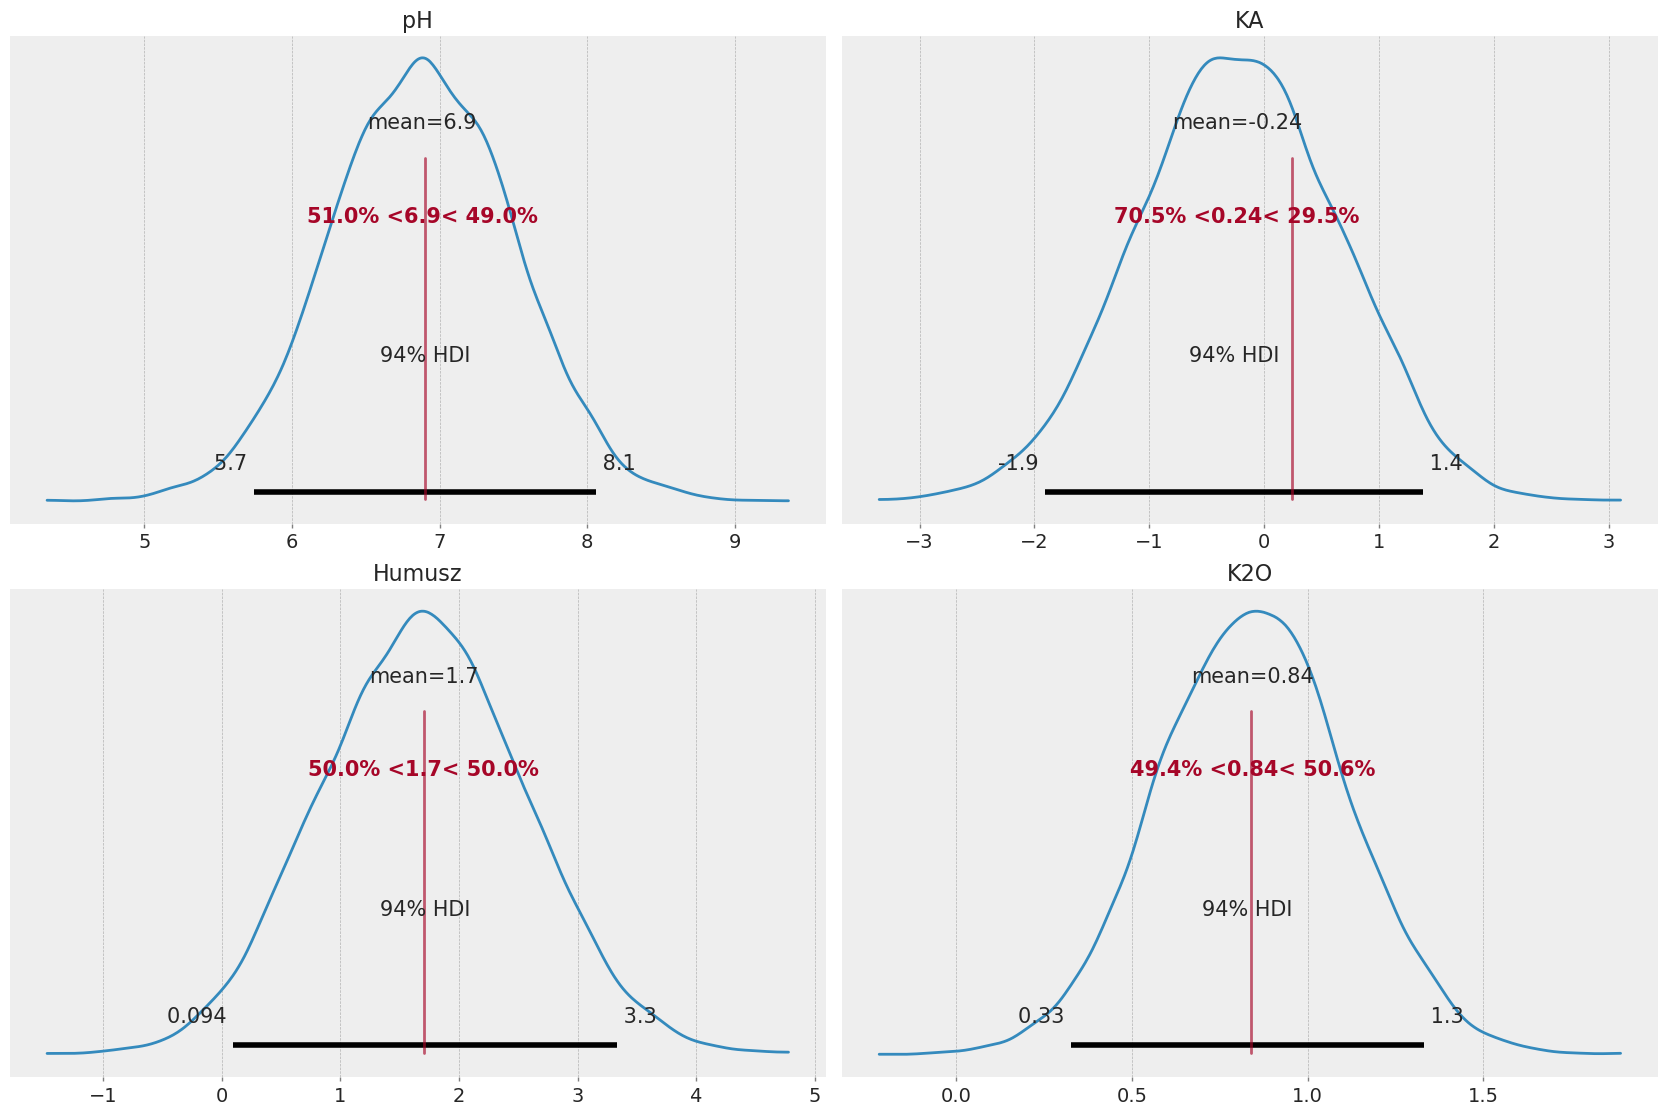

In [23]:
#Plot Posterior densities for a few selected variables
az.plot_posterior(trace, var_names=['pH', 'Humusz', "KA", "K2O"], filter_vars="regex", ref_val=[6.9,0.24,1.7,0.84], grid=(2,2) )
plt.savefig("./figures/fig3.png",dpi=300);

In [24]:
#prepare a model for profit. Here will use 
seed=42
model_profit = bmb.Model("profit ~new_yield",df_complete_subset)
idata_profit = model_profit.fit(draws=3000, tune=1000,chains=4, random_seed=seed)# consider revising the numbers here based on your computer capacity

#summarizing the results
az.summary(data=idata_profit)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (14 chains in 4 jobs)
NUTS: [profit_sigma, Intercept, new_yield]


Sampling 14 chains for 1_000 tune and 3_000 draw iterations (14_000 + 42_000 draws total) took 12 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,494447.853,388532.711,-235278.439,1219346.775,1515.626,1303.826,65755.0,34839.0,1.0
new_yield,45087.729,1944.934,41481.977,48796.689,7.498,5.303,67318.0,33574.0,1.0
profit_sigma,7874244.336,209387.746,7477221.089,8261899.194,832.614,589.839,63397.0,33404.0,1.0


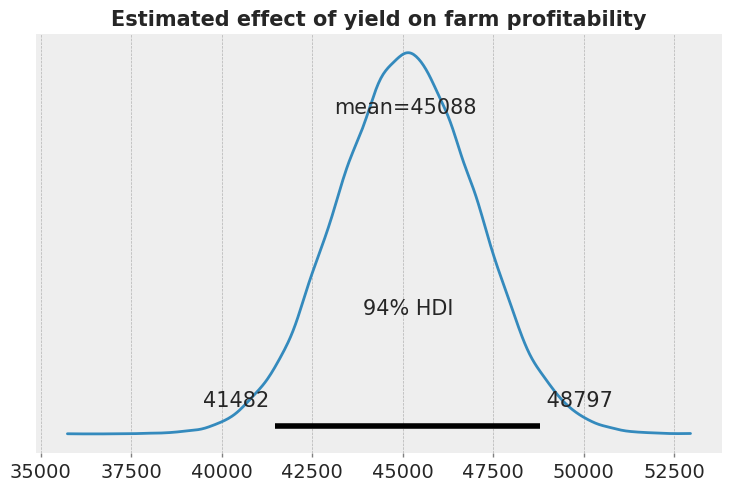

In [25]:
#Plot Posterior densities for yield on profit
az.plot_posterior(idata_profit, var_names="new_yield", filter_vars="regex")
plt.title("Estimated effect of yield on farm profitability",size=15, weight="bold")
#plt.savefig("./figures/fig4.png",dpi=300);

# End of the notebook